# QuickStart 1 - Linear Regression

This quickstart guide illustrates how *swyft* can be used to estimate 1-dim and 2-dim marginal posteriors for a simple linear regression model. The same framework can be also used to analyse, e.g., image or other complex data.  The *swfty* API is somewhat verbose right now, which emphasizes the internal workings.  We plan to change this soon.

## Imports

In [126]:
# Install swyft when on google colab
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [127]:
# Standard imports
import numpy as np
import pylab as plt
from scipy import stats
import torch

# Import swyft
import swyft
DEVICE = swyft.set_device(gpu=True)

## Linear Regression Example

### Priors

We are interested in Bayesian parameter inference, so let's first get our priors straight.  In its current version, *swyft* always assumes that model parameter $\mathbf{z}$ live with *uniform prior* on the hypercube, i.e. $z_i \in [0, 1]$.

### Our "physics simulator"

We consider a simple linear regression problem.  To this end, we define a "line simulator", which produces a line giving two input parameters (corresponding to offset and slope).

In [128]:
def simulator(z):
    "Line simulator"
    p = np.linspace(-1, 1, 10)  # Nbin = 10
    mu = z[0]*2-1 + p*(z[1]*2-1)
    return mu

The simulator generates beautiful lines.

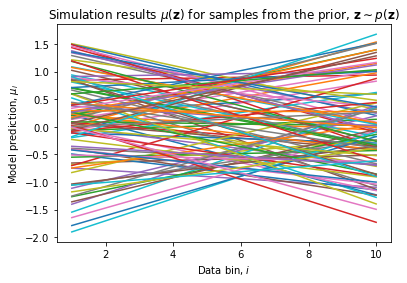

In [129]:
for _ in range(100):
    z = np.random.rand(2)
    plt.plot(range(1, 11), simulator(z));
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Simulation results ${\mu}(\mathbf{z})$ for samples from the prior, $\mathbf{z}\sim p(\mathbf{z})$");

Assuming that measurement errors for each data bin are Gaussian, a typical likelihood-based analysis would now exploit the $\chi^2$ function
$$
\chi^2 = -2\ln p(\mathbf{x}_0|\mathbf{z}) = \sum_{i=1}^{N_\text{bins}} \frac{(\mu_i(\mathbf{z}) - x_{0,i})^2}{\sigma^2}\;,
$$
where $\mathbf{x}_0$ referes to the measured flux, $\boldsymbol{\mu}(\mathbf{z})$ is the result of the line simulator model given model parameters $\textbf{z}$, $\sigma$ refers to the standard deviation of the measurement noise, and $N_\text{bins} = 10$ is the number of bins. This is *not* will do here.

### Our "detector noise"

Instead, a likelihood-free (or simulator based) analysis is based on random draws from the likelihood (aka *forward model*), $\mathbf{x}\sim p(\mathbf{x}|\mathbf{z})$.  Since we are assuming in the current example that measurement noise is Gaussian, we just have to add zero-mean Gaussian noise to the simulator results.  We do this with a separate function.

In [130]:
def noise(mu, z = None, sigma=0.1):
    n = np.random.randn(*mu.shape)*sigma
    x = mu + n
    return x

Now we can generate noisy lines!

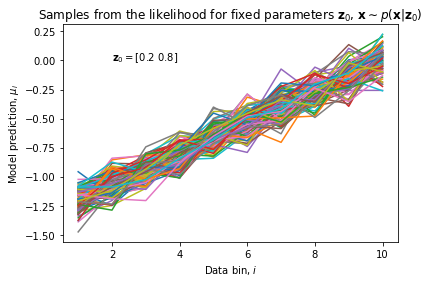

In [131]:
z0 = np.array([0.2, 0.8])  # Some fixed parameters

for _ in range(100):
    plt.plot(range(1, 11), noise(simulator(z0)));
plt.annotate("$\mathbf{z}_0 =$"+str(z0), (2, 0));
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Samples from the likelihood for fixed parameters $\mathbf{z}_0$, $\mathbf{x} \sim p(\mathbf{x}|\mathbf{z}_0)$");

### Generative models

Data scientists actually like to talk about *generative models*.  This refers simply to a sampler that both generates a random draw from the prior, $p(\mathbf{z})$, and subsequently a corresponding random draw from the forward model: $\mathbf{x}, \mathbf{z} \sim p(\mathbf{x}|\mathbf{z}) p(\mathbf{z})$.
Such $(\mathbf{x},\mathbf{z})$ pairs are samples from the generative model.  Drawing from the generative model and throwing away $\mathbf{z}$ is equivalent to sampling from the marginal likelihood (aka Bayesian evidence), $\mathbf{x} \sim p(\mathbf{x})$.

Let us plot random samples from the marginal likelihood!  We also show in red a sample from the forward model for our specific reference parameters ($\mathbf{z}_0$): $\mathbf{x}_0 \sim p(\textbf{x}|\textbf{z}_0)$.

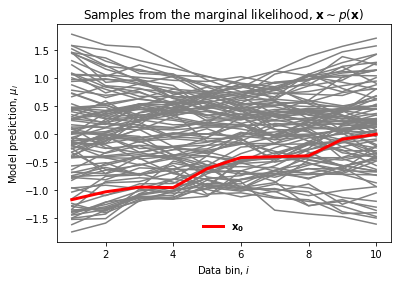

In [132]:
for _ in range(100):
    plt.plot(range(1, 11), noise(simulator(np.random.rand(2))), color='0.5');
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Samples from the marginal likelihood, $\mathbf{x} \sim p(\mathbf{x})$");

# Define mock data
x0 = noise(simulator(z0))
plt.plot(range(1, 11), x0, lw = 3, color='r', label = "$\mathbf{x_0}$")
plt.legend(frameon = False)

Below, we will solve the inverse problem and derive the posterior $p(\mathbf{z}|\mathbf{x}_0)$.

Additional information: The noise could be also simulated within the function `simulator`, and the function `noise` could just do nothing. However, often the physics simulation is slow, but adding (Gaussian, Poission, etc) measurement noise is fast.  In these cases the split functions enable the train networks with different noise realizations without rerunning the simulator.

## Parameter estimation with *swyft*

Let's now discuss how to perform parameter estimation with *swyft*.

### Boiler plate implementation of analysis steps (can be skipped on first reading)

The below function implements the required analysis steps in a rather verbose and explicit way.  In later versions of *swyft* we plan to abstract away much of the boiler plate code.

In [135]:
def run(x0, simulator, noise = None, cache = None, n_train = 10000, zdim = None, n_rounds = 3, device = 'cpu', max_epochs = 10, batch_size = 64,  lr_schedule = [1e-3]):
    if cache is None:
        cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)
    intensities = []
    res = []
    intensity = swyft.get_unit_intensity(expected_n=n_train, dim=zdim)
    intensities.append(intensity)
    for i in range(n_rounds):
        if i == 0:
            intensity = swyft.get_unit_intensity(expected_n=n_train, dim=zdim)
        else:
            intensity = swyft.get_constrained_intensity(expected_n=n_train, ratio_estimator=res[-1], x0=x0, threshold=1e-5)
        intensities.append(intensity)   
        cache.grow(intensities[-1])
        cache.simulate(simulator)
        points = swyft.Points(cache, intensities[-1], noise)
        re = swyft.RatioEstimator(points, device=device)
        res.append(re)
        res[-1].train(max_epochs=max_epochs, batch_size=batch_size, lr_schedule=lr_schedule)
    return points, res[-1]

### Run the analysis

Now we can run the analysis. The function `run` takes as input the target observation $\mathbf{x}_0$, the dimensionality of the parameter space $\mathbf{z}$, the simulator function and the (optional) noise function.

The analysis steps involve:
- Creation of simulation cache in memory
- Filling the simulation cache with parameter samples from the prior
- Running simulations for these parameter samples
- Training a neural network to estimate the posterior

In [136]:
points, re = run(x0, simulator, zdim = 2, noise = noise, device = DEVICE)

Simulate:   1%|▏         | 147/10034 [00:00<00:06, 1463.53it/s]

Creating new cache.
Adding 10034 new samples. Run simulator!


Simulate: 100%|██████████| 10034/10034 [00:06<00:00, 1488.99it/s]


yshape (shape of features between head and legs): 10
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 22.12843883037567
Validation loss: 24.703320026397705
Total epochs: 2


Simulate:   2%|▏         | 146/8223 [00:00<00:05, 1455.72it/s]

Constrained posterior area: 0.18142774974677986
Adding 8223 new samples. Run simulator!


Simulate: 100%|██████████| 8223/8223 [00:05<00:00, 1455.55it/s]


yshape (shape of features between head and legs): 10
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 41.257768869400024
Validation loss: 35.06201219558716
Validation loss: 34.03860259056091
Validation loss: 36.224294662475586
Total epochs: 4


In [ ]:
# 2-dim posteriors
re2 = swyft.RatioEstimator(points, combinations = [[0, 1]], device=DEVICE)
re2.train(max_epochs=5, batch_size=64, lr_schedule=[1e-3, 3e-4, 1e-4])

yshape (shape of features between head and legs): 10
Start training
LR iteration 0
Validation loss: 13.036891996860504
Validation loss: 6.636137008666992
Validation loss: 6.469556391239166


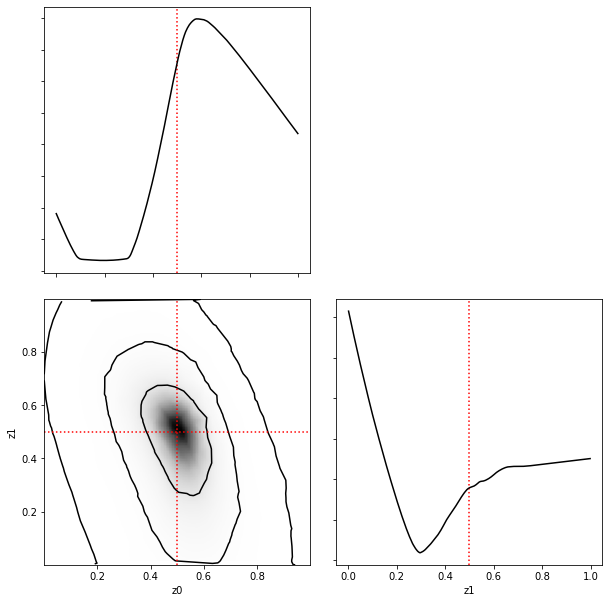

In [16]:
swyft.corner(re, re2, x0 = x0*1.0001, z0 = z0, cmap = 'Greys', dim = 10, max_n_points = 10000)